In [ ]:
#hide
%reload_ext autoreload
%autoreload 2

In [ ]:
#hide
from chitra.core import *
from chitra.utils import disable_gpu
disable_gpu()

# chitra
> <p align="center">
<img src="../chitra_banner.png" alt="chitra">
</p>

![](https://www.code-inspector.com/project/16652/score/svg)
![](https://www.code-inspector.com/project/16652/status/svg)

## What is chitra?

**chitra** (**चित्र**) is an image utility library for Deep Learning tasks. *(It is not image-processing library)*

chitra reduces image data loading boilerplates for classification and object-detection.

It can also generate bounding-boxes from the annotated dataset.

If you have more use cases please [**raise an issue**](https://github.com/aniketmaurya/chitra/issues/new/choose) with the feature you want.

## Installation

### Using pip (recommended)

`pip install -U chitra`

### From source

```
git clone https://github.com/aniketmaurya/chitra.git
cd chitra
pip install -e .
```

## Usage

### Loading data for image classification



In [ ]:
import numpy as np
import tensorflow as tf
import chitra
from chitra.dataloader import Clf, show_batch
import matplotlib.pyplot as plt

In [ ]:
#hide
# cat_dog_path = '/data/aniket/catdog/train/'
cat_dog_path = '/Users/aniket/Pictures/data/train'

In [ ]:
clf_dl = Clf()
data = clf_dl.from_folder(cat_dog_path, target_shape=(224, 224))

clf_dl.show_batch(8, figsize=(8,8))

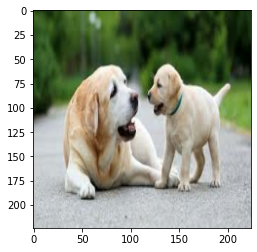

In [ ]:
for e in data.take(1):
    image = e[0].numpy().astype('uint8')
    label = e[1].numpy()
plt.imshow(image)
plt.show()

## Image datagenerator
Dataset class provides the flexibility to load image dataset by updating components of the class.

Components of Dataset class are:
- image file generator
- resizer
- label generator
- image loader

These components can be updated with custom function by the user according to their dataset structure. For example the Tiny Imagenet dataset is organized as-

```
train_folder/
.....folder1/
    .....file.txt
    .....folder2/
           .....image1.jpg
           .....image2.jpg
                     .
                     .
                     .
           ......imageN.jpg
                    
                      
```

The inbuilt file generator search for images on the `folder1`, now we can just update the `image file generator` and rest of the functionality will remain same.

**Dataset also support progressive resizing of images.**

### Updating component

In [ ]:
#hide
# data_path = '/data/aniket/tiny-imagenet/data/tiny-imagenet-200/train'
# data_path = '/Users/aniket/Pictures/data/train'
data_path = '/Users/aniket/Pictures/data/tiny-imagenet-200/train'

In [ ]:
from chitra.datagenerator import Dataset
from glob import glob

ds = Dataset(data_path)
# it will load the folders and NOT images
ds.filenames[:3]

No item present in the image size list


['/Users/aniket/Pictures/data/tiny-imagenet-200/train/n02795169/n02795169_boxes.txt',
 '/Users/aniket/Pictures/data/tiny-imagenet-200/train/n02795169/images',
 '/Users/aniket/Pictures/data/tiny-imagenet-200/train/n02769748/images']

In [ ]:
def load_files(path):
    return glob(f'{path}/*/images/*')

def get_label(path):
    return path.split('/')[-3]
    
ds.update_component('get_filenames', load_files)
ds.filenames[:3]

get_filenames updated with <function load_files at 0x7fad6916d0e0>
No item present in the image size list


['/Users/aniket/Pictures/data/tiny-imagenet-200/train/n02795169/images/n02795169_369.JPEG',
 '/Users/aniket/Pictures/data/tiny-imagenet-200/train/n02795169/images/n02795169_386.JPEG',
 '/Users/aniket/Pictures/data/tiny-imagenet-200/train/n02795169/images/n02795169_105.JPEG']

### Progressive resizing

In [ ]:
image_sz_list = [(28, 28), (32, 32), (64, 64)]

ds = Dataset(data_path, image_size=image_sz_list)
ds.update_component('get_filenames', load_files)
ds.update_component('get_label', get_label)


print()
# first call to generator
for img, label in ds.generator():
    print('first call to generator:', img.shape)
    break

# seconds call to generator
for img, label in ds.generator():
    print('seconds call to generator:', img.shape)
    break

# third call to generator
for img, label in ds.generator():
    print('third call to generator:', img.shape)
    break


get_filenames updated with <function load_files at 0x7fad6916d0e0>
get_label updated with <function get_label at 0x7fad6916d8c0>

first call to generator: (28, 28, 3)
seconds call to generator: (32, 32, 3)
third call to generator: (64, 64, 3)


### tf.data support
Creating a `tf.data` dataloader was never as easy as this one liner. It converts the Python generator into `tf.data.Dataset` for a faster data loading, prefetching, caching and everything provided by tf.data.

In [ ]:
image_sz_list = [(28, 28), (32, 32), (64, 64)]

ds = Dataset(data_path, image_size=image_sz_list)
ds.update_component('get_filenames', load_files)
ds.update_component('get_label', get_label)

dl = ds.get_tf_dataset()

for e in dl.take(1):
    print(e[0].shape)

for e in dl.take(1):
    print(e[0].shape)

for e in dl.take(1):
    print(e[0].shape)

get_filenames updated with <function load_files at 0x7fad6916d0e0>
get_label updated with <function get_label at 0x7fad6916d8c0>
(28, 28, 3)
(32, 32, 3)
(64, 64, 3)


## Trainer
The Trainer class inherits from `tf.keras.Model`, it contains everything that is required for training.
It exposes trainer.cyclic_fit method which trains the model using Cyclic Learning rate discovered by [Leslie Smith](https://arxiv.org/abs/1506.01186).

In [ ]:
from chitra.trainer import Trainer, create_cnn
from chitra.datagenerator import Dataset
from PIL import Image

In [ ]:
ds = Dataset(cat_dog_path, image_size=(224,224))
model = create_cnn('mobilenetv2', num_classes=2, name='Cat_Dog_Model')
trainer = Trainer(ds, model)
# trainer.summary()

In [ ]:
#hide
import tensorflow as tf

In [ ]:
trainer.compile2(batch_size=8,
                 optimizer=tf.keras.optimizers.SGD(1e-3, momentum=0.9, nesterov=True),
                 lr_range=(1e-6, 1e-3),
                 loss='binary_crossentropy', 
                 metrics=['binary_accuracy'])

Model compiled!


In [ ]:
trainer.cyclic_fit(epochs=5,
                   batch_size=8,
                   lr_range=(0.00001, 0.0001),                   
                  )

cyclic learning rate already set!
Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 6.4702 - binary_accuracy: 0.2500
Epoch 2/5
Returning the last set size which is: (224, 224)
1/1 [==============================] - 0s 965us/step - loss: 5.9033 - binary_accuracy: 0.5000
Epoch 3/5
Returning the last set size which is: (224, 224)
1/1 [==============================] - 0s 977us/step - loss: 5.9233 - binary_accuracy: 0.5000
Epoch 4/5
Returning the last set size which is: (224, 224)
1/1 [==============================] - 0s 979us/step - loss: 2.1408 - binary_accuracy: 0.7500
Epoch 5/5
Returning the last set size which is: (224, 224)
1/1 [==============================] - 0s 982us/step - loss: 1.9062 - binary_accuracy: 0.8750


## Model Visualization
It is important to understand what is going inside the model. Techniques like GradCam and Saliency Maps can visualize what the Network is learning. `trainer` module has InterpretModel class which creates GradCam and GradCam++ visualization with almost no additional code.

In [ ]:
from chitra.trainer import InterpretModel
trainer = Trainer(ds, create_cnn('mobilenetv2', num_classes=1000, keras_applications=False))
model_interpret = InterpretModel(True, trainer)

In [ ]:
#hide
trainer.NUM_CLASSES=1000

Returning the last set size which is: (224, 224)
index: 282


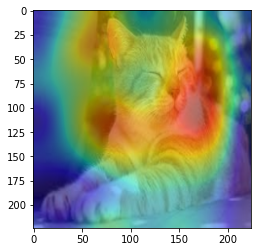

Egyptian Mau


In [ ]:
image = ds[1][0].numpy().astype('uint8')
image = Image.fromarray(image)
model_interpret(image)
print(IMAGENET_LABELS[285])

Labrador Retriever
Returning the last set size which is: (224, 224)
index: 281


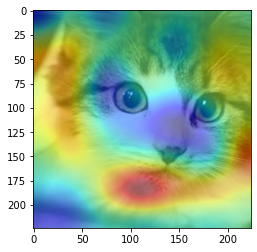

In [ ]:
#hide
image = ds[3][0].numpy().astype('uint8')
image = Image.fromarray(image)
print(IMAGENET_LABELS[208])
model_interpret(image)

## Data Visualization

### Image annotation

Thanks to [**fizyr**](https://github.com/fizyr/keras-retinanet) keras-retinanet.

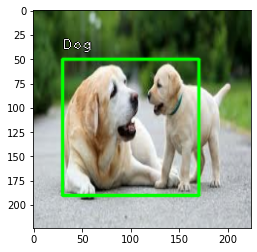

In [ ]:
from chitra.visualization import draw_annotations

labels = np.array([label])
bbox = np.array([[30, 50, 170, 190]])
label_to_name = lambda x: 'Cat' if x==0 else 'Dog'

draw_annotations(image, ({'bboxes': bbox, 'labels':labels,}), label_to_name=label_to_name)
plt.imshow(image)
plt.show()

## Utils

Limit GPU memory or enable dynamic GPU memory growth for Tensorflow

In [ ]:
from chitra.utils import limit_gpu, gpu_dynamic_mem_growth

# limit the amount of GPU required for your training
limit_gpu(gpu_id=0, memory_limit=1024*2)

No GPU:0 found in your system!


In [ ]:
gpu_dynamic_mem_growth()

No GPU found on the machine!


## Contributing

Contributions of any kind are welcome. Please check the [**Contributing Guidelines**](https://github.com/aniketmaurya/chitra/blob/master/CONTRIBUTING.md) before contributing.

In [ ]:
#hide
from nbdev.export import notebook2script;notebook2script('index.ipynb')

Converted index.ipynb.
